<a href="https://colab.research.google.com/github/tejasvi541/Machine-Learning/blob/main/AnimeFacesGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using openDataset module to load data from the Kaggle

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tejasvii
Your Kaggle Key: ··········


  6%|▌         | 24.0M/395M [00:00<00:01, 246MB/s]

100%|██████████| 395M/395M [00:01<00:00, 291MB/s]


In [ ]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR+'/images')[:100])

['51756_2015.jpg', '32318_2011.jpg', '22273_2008.jpg', '6267_2003.jpg', '56909_2017.jpg', '63249_2019.jpg', '517_2000.jpg', '38502_2012.jpg', '54624_2016.jpg', '31856_2010.jpg', '21855_2008.jpg', '2333_2001.jpg', '58388_2017.jpg', '9907_2004.jpg', '60340_2018.jpg', '54025_2016.jpg', '26787_2009.jpg', '41483_2013.jpg', '26837_2009.jpg', '1241_2001.jpg', '13740_2006.jpg', '13487_2006.jpg', '12091_2005.jpg', '6358_2003.jpg', '12593_2005.jpg', '52402_2015.jpg', '57724_2017.jpg', '994_2000.jpg', '62557_2019.jpg', '57136_2017.jpg', '56389_2017.jpg', '20953_2008.jpg', '33735_2011.jpg', '27348_2009.jpg', '39761_2012.jpg', '33152_2011.jpg', '50561_2015.jpg', '44490_2013.jpg', '20603_2008.jpg', '35092_2011.jpg', '35_2000.jpg', '54823_2016.jpg', '48122_2014.jpg', '50658_2015.jpg', '58781_2017.jpg', '23316_2008.jpg', '57719_2017.jpg', '47069_2014.jpg', '32724_2011.jpg', '23312_2008.jpg', '33783_2011.jpg', '29815_2010.jpg', '52739_2016.jpg', '45320_2014.jpg', '33859_2011.jpg', '31716_2010.jpg', '12

### Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Creating helper function to de normalize the image tensor and display some tesnor images

In [ ]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


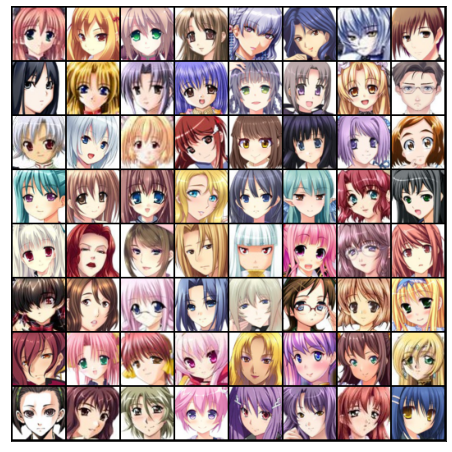

In [ ]:
show_batch(train_dl)

### Utilities to work with the GPUs
#### we define couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model and data to GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
# Move model to GPU
discriminator = to_device(discriminator, device)

In [ ]:
latent_size =128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

##### "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling."

Note that since the outputs of the TanH activation lie in the range [-1,1], we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


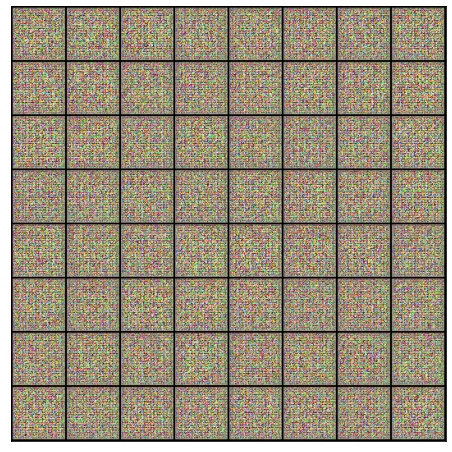

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

We first pass a batch of real images, and compute the loss, setting the target labels to 1.

Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

## Generator Training
Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


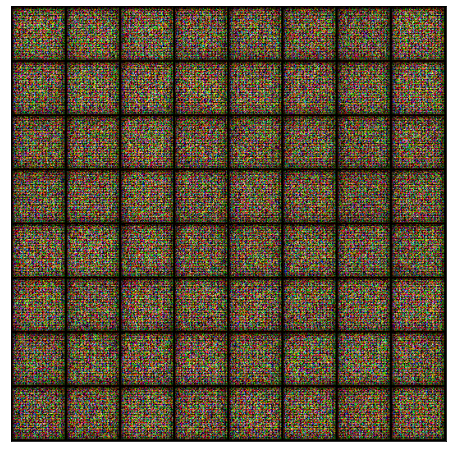

In [ ]:
save_samples(0, fixed_latent)

# Full training Loop
Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.
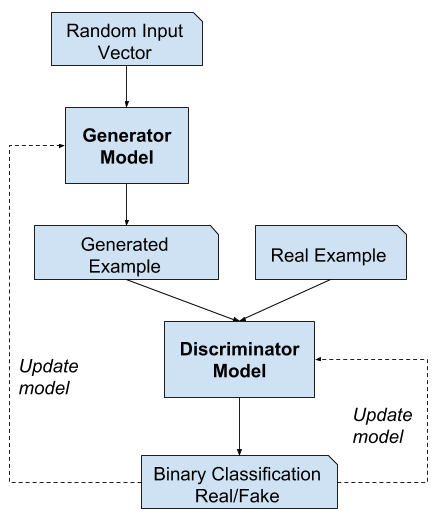

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.55, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.55, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.00025
epochs = 35

In [ ]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/35], loss_g: 3.3225, loss_d: 0.4540, real_score: 0.7781, fake_score: 0.1419
Saving generated-images-0001.png



Epoch [2/35], loss_g: 7.7027, loss_d: 0.8497, real_score: 0.9242, fake_score: 0.4773
Saving generated-images-0002.png



Epoch [3/35], loss_g: 6.8696, loss_d: 0.1487, real_score: 0.8912, fake_score: 0.0193
Saving generated-images-0003.png



Epoch [4/35], loss_g: 7.2801, loss_d: 0.4322, real_score: 0.9857, fake_score: 0.3087
Saving generated-images-0004.png



Epoch [5/35], loss_g: 9.9401, loss_d: 0.4131, real_score: 0.7148, fake_score: 0.0004
Saving generated-images-0005.png



Epoch [6/35], loss_g: 5.5171, loss_d: 0.1512, real_score: 0.9949, fake_score: 0.1246
Saving generated-images-0006.png



Epoch [7/35], loss_g: 5.2986, loss_d: 0.2461, real_score: 0.8378, fake_score: 0.0091
Saving generated-images-0007.png



Epoch [8/35], loss_g: 6.2442, loss_d: 0.1558, real_score: 0.8918, fake_score: 0.0085
Saving generated-images-0008.png



Epoch [9/35], loss_g: 8.7456, loss_d: 0.2811, real_score: 0.9992, fake_score: 0.1749
Saving generated-images-0009.png



Epoch [10/35], loss_g: 9.9889, loss_d: 0.1006, real_score: 0.9330, fake_score: 0.0001
Saving generated-images-0010.png



Epoch [11/35], loss_g: 8.8836, loss_d: 0.1156, real_score: 0.9913, fake_score: 0.0937
Saving generated-images-0011.png



Epoch [12/35], loss_g: 8.7748, loss_d: 0.1266, real_score: 0.9777, fake_score: 0.0941
Saving generated-images-0012.png



Epoch [13/35], loss_g: 9.5830, loss_d: 0.0015, real_score: 0.9986, fake_score: 0.0001
Saving generated-images-0013.png



Epoch [14/35], loss_g: 8.1235, loss_d: 0.0368, real_score: 0.9728, fake_score: 0.0025
Saving generated-images-0014.png



Epoch [15/35], loss_g: 5.6244, loss_d: 0.0863, real_score: 0.9505, fake_score: 0.0284
Saving generated-images-0015.png



Epoch [16/35], loss_g: 7.3264, loss_d: 0.1299, real_score: 0.9258, fake_score: 0.0004
Saving generated-images-0016.png



Epoch [17/35], loss_g: 8.0386, loss_d: 0.0670, real_score: 0.9780, fake_score: 0.0382
Saving generated-images-0017.png



Epoch [18/35], loss_g: 4.3313, loss_d: 0.1128, real_score: 0.9249, fake_score: 0.0199
Saving generated-images-0018.png



Epoch [19/35], loss_g: 6.7865, loss_d: 0.0337, real_score: 0.9894, fake_score: 0.0220
Saving generated-images-0019.png



Epoch [20/35], loss_g: 6.2286, loss_d: 0.0210, real_score: 0.9946, fake_score: 0.0150
Saving generated-images-0020.png



Epoch [21/35], loss_g: 7.5011, loss_d: 0.0391, real_score: 0.9786, fake_score: 0.0165
Saving generated-images-0021.png



Epoch [22/35], loss_g: 6.7654, loss_d: 0.0432, real_score: 0.9629, fake_score: 0.0012
Saving generated-images-0022.png



Epoch [23/35], loss_g: 8.0832, loss_d: 0.0898, real_score: 0.9975, fake_score: 0.0755
Saving generated-images-0023.png



Epoch [24/35], loss_g: 4.1587, loss_d: 0.1506, real_score: 0.9114, fake_score: 0.0139
Saving generated-images-0024.png



Epoch [25/35], loss_g: 21.9016, loss_d: 0.0726, real_score: 0.9521, fake_score: 0.0013
Saving generated-images-0025.png



Epoch [26/35], loss_g: 7.0559, loss_d: 0.0787, real_score: 0.9642, fake_score: 0.0345
Saving generated-images-0026.png



Epoch [27/35], loss_g: 10.2250, loss_d: 0.0221, real_score: 0.9997, fake_score: 0.0179
Saving generated-images-0027.png



Epoch [28/35], loss_g: 7.4301, loss_d: 0.1041, real_score: 0.9724, fake_score: 0.0447
Saving generated-images-0028.png



Epoch [29/35], loss_g: 6.4678, loss_d: 0.0498, real_score: 0.9721, fake_score: 0.0107
Saving generated-images-0029.png



Epoch [30/35], loss_g: 6.6585, loss_d: 0.0433, real_score: 0.9715, fake_score: 0.0097
Saving generated-images-0030.png



Epoch [31/35], loss_g: 34.8021, loss_d: 0.1807, real_score: 1.0000, fake_score: 0.1214
Saving generated-images-0031.png



Epoch [32/35], loss_g: 18.6344, loss_d: 0.0327, real_score: 0.9718, fake_score: 0.0017
Saving generated-images-0032.png



Epoch [33/35], loss_g: 10.2510, loss_d: 0.1311, real_score: 0.9049, fake_score: 0.0043
Saving generated-images-0033.png



Epoch [34/35], loss_g: 18.5698, loss_d: 0.0341, real_score: 0.9694, fake_score: 0.0002
Saving generated-images-0034.png



Epoch [35/35], loss_g: 10.0576, loss_d: 0.0939, real_score: 0.9845, fake_score: 0.0715
Saving generated-images-0035.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

In [ ]:
import cv2
import os

vid_fname = 'gans_training_human.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

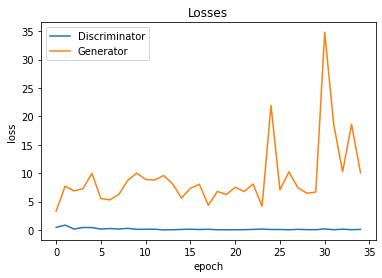

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');